# Photonic Lantern lab experiments data analysis

In [1]:
%matplotlib inline

In [31]:
from __future__ import division, print_function, unicode_literals
from glob import glob
from os import path
import re
from astropy import units as u
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt

First step is camera calibration. Have a bunch of darks and flats, want to derive bias levels, dark currents, read noise and gain, also check linearity and saturation levels.

In [3]:
dark_path = '../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks'

The 8th, 9th & 10th repeats are hiding in subdirectories. Some fiddling is required to get all the paths to all the data files sorted out.

In [4]:
data_paths = {}
exp_pattern = re.compile('(^[\d+\.]?\d+)') # Sequence of digits (possibly with decimal point) at start of string

for dpath in (glob(path.join(dark_path, "*.png")) + glob(path.join(dark_path, "*/*.png"))):
    # Parse filename to extract exposure time, in microseconds.
    exp_time = float((exp_pattern.match(path.basename(dpath))).group()) * u.us
    if exp_time in data_paths.keys():
        # If we've already got data file(s) with this exp_time add to the list
        data_paths[exp_time].append(dpath)
    else:
        # Otherwise create a new list
        data_paths[exp_time] = [dpath,]

Check what we've got

In [5]:
for exp_time in data_paths.keys():
    print(exp_time)
    for dpath in data_paths[exp_time]:
        print(dpath)

15000.0 us
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_2.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_1.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_4.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_6.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_7.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_5.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/15000_3.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/9/15000.png
../FarFields/s_sstever/Documents/ipython/Data/Infrared/3136 3176 1309 postcalibration darks/10/15000.png
../FarFields/s_sstever/Documents/ipython/Data/Infrar

In [20]:
i = imread(data_paths[3000 * u.us][2], mode='I')

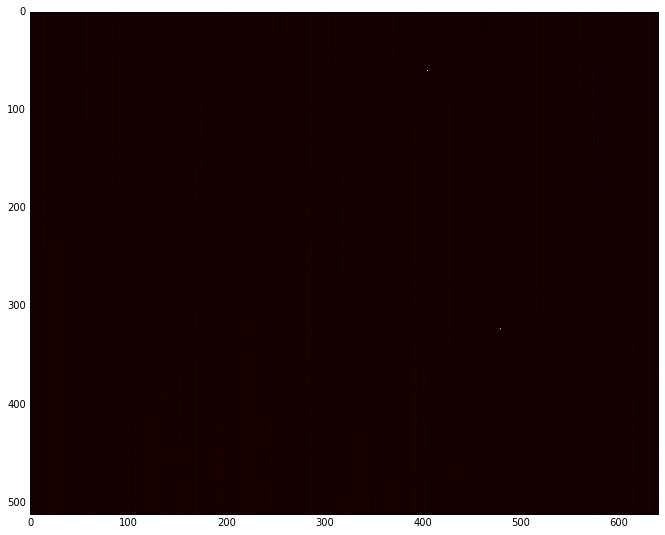

In [21]:
plt.imshow(i, cmap='hot')
plt.gcf().set_size_inches(12,9)

Load all the data (it's not that big) in a form that's OK to work with

In [36]:
exp_times = []
all_darks = []

for exp_time in data_paths.keys():
    for dpath in data_paths[exp_time]:
        exp_times.append(exp_time)
        all_darks.append(imread(dpath, mode='I'))

exp_times = u.Quantity(exp_times)
all_darks = np.array(all_darks) * u.adu

In [37]:
exp_times

<Quantity [  15000.,  15000.,  15000.,  15000.,  15000.,  15000.,  15000.,
             15000.,  15000.,  15000.,  24000.,  24000.,  24000.,  24000.,
             24000.,  24000.,  24000.,  24000.,  24000.,  24000.,   3000.,
              3000.,   3000.,   3000.,   3000.,   3000.,   3000.,   3000.,
              3000.,   3000.,  70000.,  70000.,  70000.,  70000.,  70000.,
             70000.,  70000.,  70000.,  70000.,  70000.,  27000.,  27000.,
             27000.,  27000.,  27000.,  27000.,  27000.,  27000.,  27000.,
             27000.,  12000.,  12000.,  12000.,  12000.,  12000.,  12000.,
             12000.,  12000.,  12000.,  12000., 100000., 100000., 100000.,
            100000., 100000., 100000., 100000., 100000., 100000., 100000.,
             21000.,  21000.,  21000.,  21000.,  21000.,  21000.,  21000.,
             21000.,  21000.,  21000.,  80000.,  80000.,  80000.,  80000.,
             80000.,  80000.,  80000.,  80000.,  80000.,  80000.,  18000.,
             18000.,  180

In [35]:
all_darks.shape

(180, 512, 640)

Pick a random pixel or two and check out the data

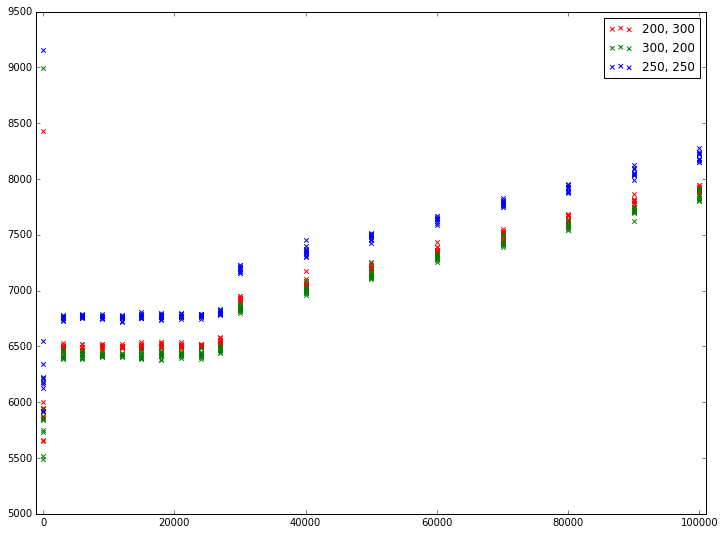

In [52]:
x0, y0 = 200, 300
x1, y1 = 300, 200
x2, y2 = 250, 250
plt.scatter(exp_times, all_darks[:,y0,x0], marker='x', c='r', label='200, 300')
plt.scatter(exp_times, all_darks[:,y1,x1], marker='x', c='g', label='300, 200')
plt.scatter(exp_times, all_darks[:,y2,x2], marker='x', c='b', label='250, 250')
plt.gcf().set_size_inches(12,9)
plt.xlim(-1000,101000)
plt.legend(loc='best')

Looks like some of there are errors with the exposure times. Try dividing all the exposure times below 30000 us by 10 to see if that restores linearity.

In [58]:
fixed_exp_times = u.Quantity([exp_time/10 if exp_time < 30000 * u.us else exp_time for exp_time in exp_times])

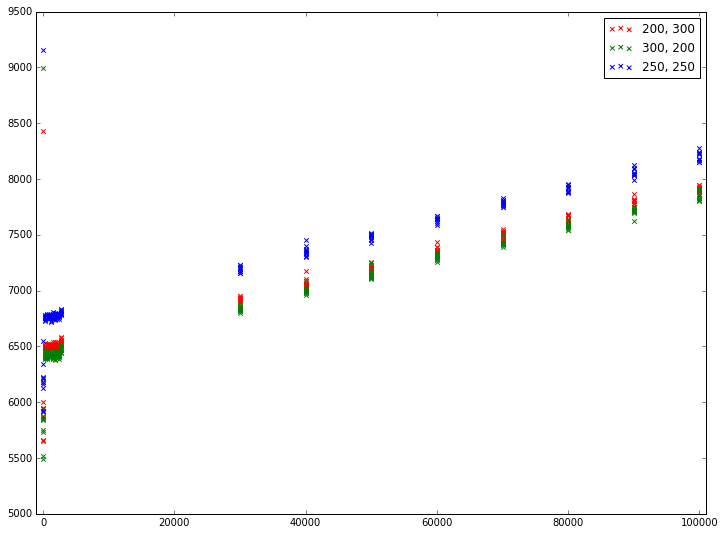

In [59]:
plt.scatter(fixed_exp_times, all_darks[:,y0,x0], marker='x', c='r', label='200, 300')
plt.scatter(fixed_exp_times, all_darks[:,y1,x1], marker='x', c='g', label='300, 200')
plt.scatter(fixed_exp_times, all_darks[:,y2,x2], marker='x', c='b', label='250, 250')
plt.gcf().set_size_inches(12,9)
plt.xlim(-1000,101000)
plt.legend(loc='best')

Looks linear, for now will assume that the exposure times were incorrectly set by a factor of 10.

Now do some fitting (or rather Bayesian inference) to determine bias levels and dark currents. As long as the detector is reasonably well behaved the following generative model should be suitable.

$C = (B + P(Dt) + N(0,R))/g$, where $C$ is counts in ADU, $B$ is the bias level in electrons (TBD), $P$ is a Poisson distributed random variable with mean $Dt$, $D$ is the dark current in electrons per second (TBD), t is the exposure time, $N$ is a normally (Gaussian) distributed random variable with mean 0 and standard deviation $R$, $R$ is the read noise in electrons (unknown) and $g$ is the gain in electrons per ADU (unknown).